In [4]:
%load_ext autoreload
%autoreload 2
import torch
import networkx as nx
import matplotlib.pyplot as plt
import copy
import itertools
import numpy as np

import sys
sys.path.insert(0, "../models/")
sys.path.insert(0, "../lidar/")
from fourier_nn import FourierNet
from lidar import RandomPoseLidarDataset, TrajectoryLidarDataset

torch.set_default_tensor_type(torch.DoubleTensor)

In [5]:
# Make the graph
N = 5
G = nx.wheel_graph(N)

In [22]:
# Setup models
shape = [2, 86, 32, 32, 32, 1]
base_model = FourierNet(shape, scale=0.01)
num_params = sum([param.nelement() for param in base_model.parameters()])
mem_params = sum([param.nelement() * param.element_size() for param in base_model.parameters()])
print("Number of model parameters: ", num_params)
print("Memory footprint of model: ", mem_params * 1e-3, " KB")

n = torch.nn.utils.parameters_to_vector(base_model.parameters()).shape[0]

models = {i : copy.deepcopy(base_model) for i in range(N)}

Number of model parameters:  5187
Memory footprint of model:  41.496  KB


In [23]:
# Setup data
data_type = "random" # {random, trajectory}
batch_size = 10000 # number of (x, y, z) points used to compute each grad
validation_set_size = 300 # number of scans in the validation set

num_beams = 20
beam_samps = 20
scan_dist = 0.2
num_scans = 1200

traj_paths = ["../planner/waypoint_path1.npy", "../planner/waypoint_path2.npy", "../planner/waypoint_path3.npy", "../planner/waypoint_path4.npy", "../planner/waypoint_path5.npy", "../planner/waypoint_path6.npy"]
img_dir = "../floorplans/32_b.png"

train_loaders = {} # Dictionary of dataloaders for each node
train_iters = {} # Dictionary of iterators for each node

if data_type == "random":
    for i in range(N):
        node_set = RandomPoseLidarDataset(img_dir, num_beams, scan_dist, beam_samps, num_scans)
        train_loaders[i] = torch.utils.data.DataLoader(node_set, batch_size=batch_size, shuffle=True)
        train_iters[i] = iter(train_loaders[i])
elif data_type == "trajectory":
    for i in range(N):
        traj = np.load(traj_paths[i])
        node_set = TrajectoryLidarDataset(img_dir, num_beams, scan_dist, beam_samps, traj)
        train_loaders[i] = torch.utils.data.DataLoader(node_set, batch_size=batch_size, shuffle=True)
        train_iters[i] = iter(train_loaders[i])
else:
    print("Not a supported data_type")

val_set = RandomPoseLidarDataset(img_dir, num_beams, scan_dist, beam_samps, validation_set_size)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)

In [24]:
def primal_update(data_loader, data_iter, model, base_loss, dual, thj, rho, lr, max_its):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for k in range(max_its):
        # Load the batch
        try:
            batch = next(data_iter)
        except StopIteration:
            data_iter = iter(data_loader)
            batch = next(data_iter)
        
        opt.zero_grad()
        
        yh = model.forward(batch["position"])
        
        # Compose CADMM Loss
        th = torch.nn.utils.parameters_to_vector(model.parameters())
        reg = torch.sum(torch.square(torch.cdist(th.reshape(1, -1), thj)))
        loss = base_loss(yh, batch["density"]) + torch.dot(th, dual) + rho * reg

        # Backprop and step
        loss.backward()
        opt.step()

def validate(base_loss, val_loader, model):
    val_loss = 0.0
    for batch in val_loader:
        with torch.no_grad():
            yh = model.forward(batch["position"])
            val_loss += base_loss(yh, batch["density"]).data.detach()
    return val_loss

def validate_all(base_loss, val_loader, models):
    minloss = float('inf')
    maxloss = float('-inf')
    avgloss = 0.0
    for i in range(len(models)):
        with torch.no_grad():
            loss = 0.0
            for batch in val_loader:
                yh = models[i].forward(batch["position"])
                loss += base_loss(yh, batch["density"]).item()
            avgloss += loss

            minloss = loss if minloss > loss else minloss
            maxloss = loss if maxloss < loss else maxloss
    avgloss = avgloss / len(models)

    return avgloss, minloss, maxloss

In [30]:
# Setup Loss and CADMM
primal_steps = 5
cadmm_iterations = 600
eval_every = 40
rho = 1.0
lr = 0.005

num_params = torch.nn.utils.parameters_to_vector(models[0].parameters()).shape[0]
base_loss = torch.nn.BCELoss()

duals = {i : torch.zeros(num_params) for i in range(N)}
obvs = torch.zeros((cadmm_iterations // eval_every + 1, N))

cnt_evals = 0
for k in range(cadmm_iterations):
    ths = {i : (torch.nn.utils.parameters_to_vector(models[i].parameters()).clone().detach()) for i in range(N)}

    for i in range(N):
        # Evaluate model
        if k % eval_every == 0 or k == cadmm_iterations - 1:
            obvs[cnt_evals, i]  = validate(base_loss, val_loader, models[i])
            obv_str = "{:.4f}".format(obvs[cnt_evals, i].item())
            print("Iteration: ", k, " | BCELoss: ", obv_str, " | Node: ", i)
        
        # Communication
        neighs = list(G.neighbors(i))
        thj = torch.stack([ths[j] for j in neighs])

        # Update the dual var
        duals[i] += rho * torch.sum(ths[i] - thj, dim=0)

        # Primal Update
        # (data_loader, data_iter, model, base_loss, dual, thj, rho, lr, max_its)
        primal_update(train_loaders[i], train_iters[i], models[i], base_loss, duals[i], thj, rho, lr, primal_steps)

            
    if k % eval_every == 0:
        cnt_evals += 1

Iteration:  0  | BCELoss:  1.8859  | Node:  0
Iteration:  0  | BCELoss:  1.8946  | Node:  1
Iteration:  0  | BCELoss:  1.8883  | Node:  2
Iteration:  0  | BCELoss:  1.8944  | Node:  3
Iteration:  0  | BCELoss:  1.8883  | Node:  4


KeyboardInterrupt: 

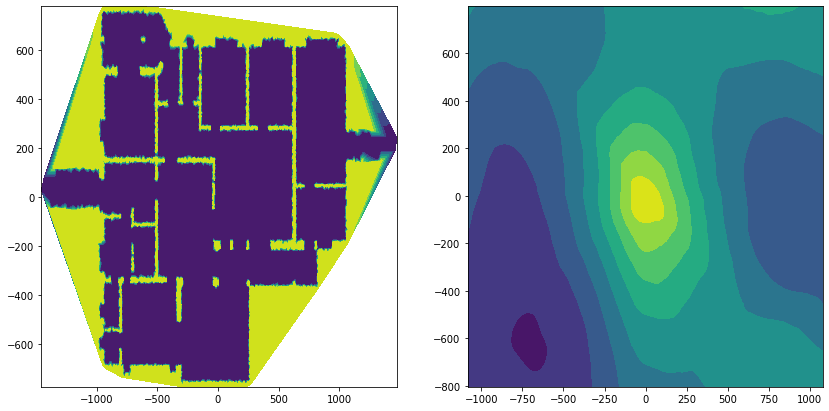

In [31]:
fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
X, Y = np.meshgrid(val_set.lidar.xs, val_set.lidar.ys)
xlocs = X[::8, ::8].reshape(-1, 1)
ylocs = Y[::8, ::8].reshape(-1, 1)
val_poses = np.hstack((xlocs, ylocs))

val_inputs = torch.Tensor(val_poses)

with torch.no_grad():
    pred_dens = models[4].forward(val_inputs)

ax0.tricontourf(val_set.scans[:, 0], val_set.scans[:, 1], val_set.scans[:, 2])
ax1.tricontourf(xlocs.flatten(), ylocs.flatten(), pred_dens.numpy().flatten())